### 导入音频并分帧 


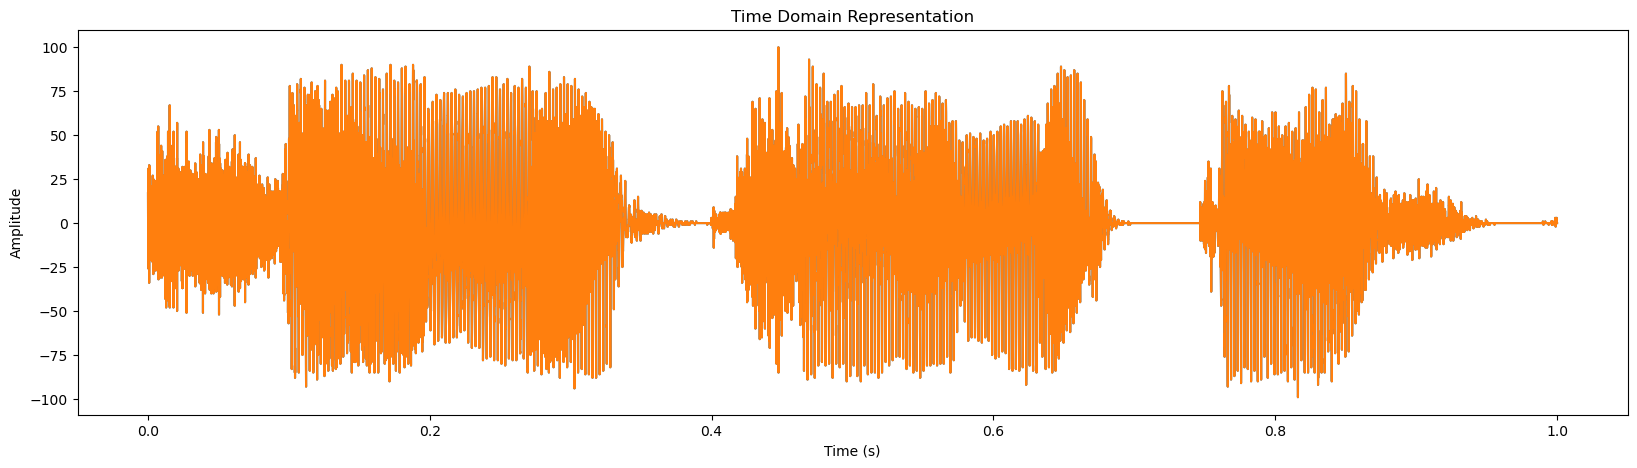

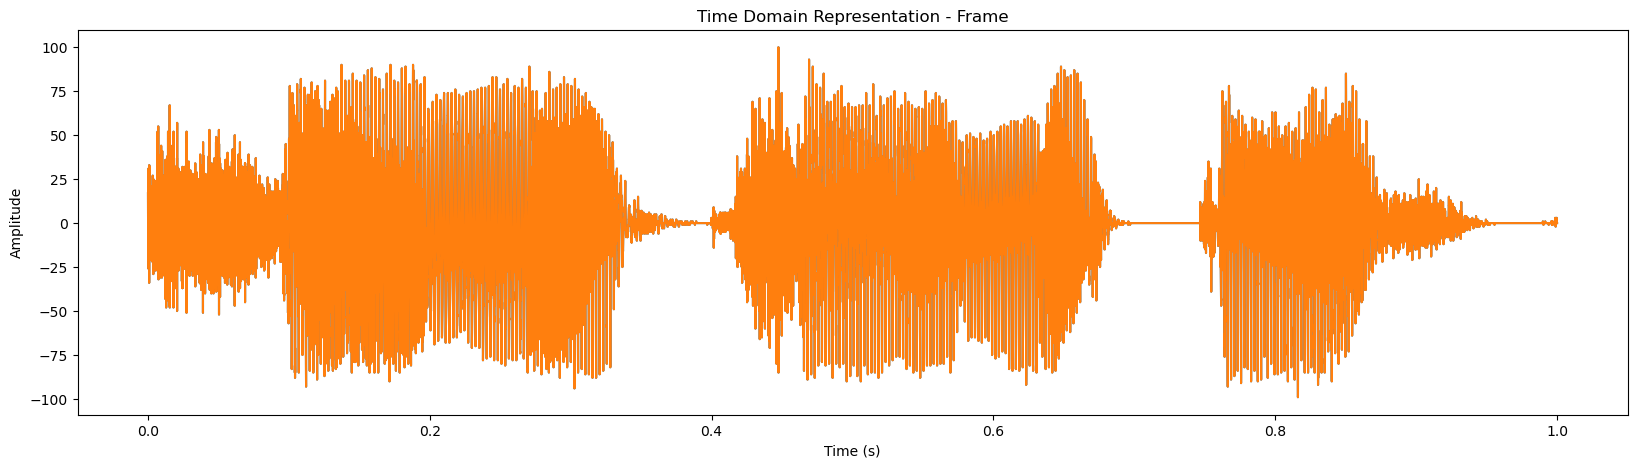

In [2]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt 
from scipy.io import wavfile

sample_rate, signal = wavfile.read('data/Anon/anon_part10.wav')

time = np.arange(0, len(signal)) / sample_rate

# 绘制时域图
plt.figure(figsize=(20, 5))
plt.plot(time, signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain Representation')
plt.show()

frame_size = len(signal)

# 将音频信号分割为四段
wav = signal


time = np.arange(0, len(wav)) / sample_rate
plt.figure(figsize=(20, 5))
plt.plot(time, wav)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Time Domain Representation - Frame')
plt.show()

### 预处理
## 1.预加重对信号应用预加重滤波器以放大高频
加入一个高通滤波器  y(t) = x(t) - α * x(t-1)实现

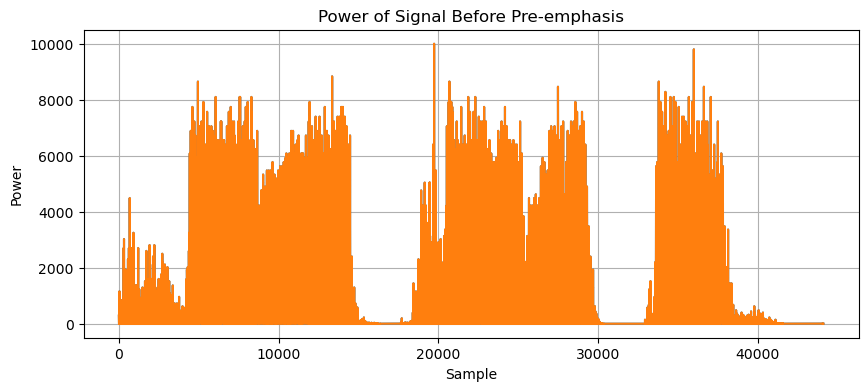

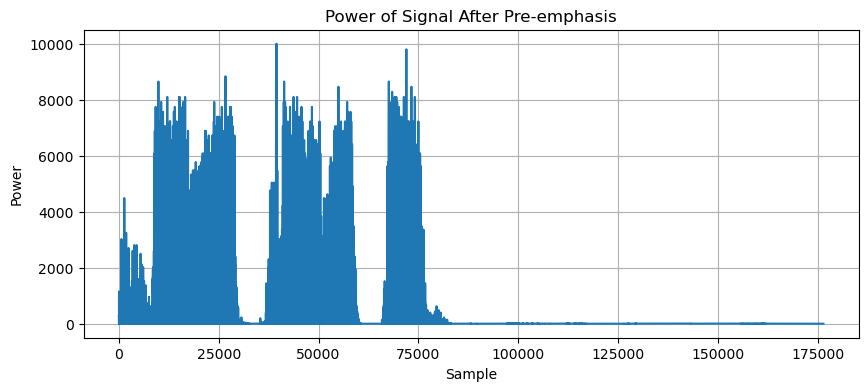

In [3]:
# 预加重系数
pre_emphasis = 0.97

# 使用numpy的差分函数实现预加重
wav1_preemphasized = np.append(wav, wav - pre_emphasis * wav)

# 计算预加重前的信号功率
power_pre = wav ** 2

# 计算预加重后的信号功率
power_post = wav1_preemphasized ** 2

# 绘制预加重前的信号功率图
plt.figure(figsize=(10, 4))
plt.plot(power_pre)
plt.title('Power of Signal Before Pre-emphasis')
plt.xlabel('Sample')
plt.ylabel('Power')
plt.grid(True)
plt.show()

# 绘制预加重后的信号功率图
plt.figure(figsize=(10, 4))
plt.plot(power_post)
plt.title('Power of Signal After Pre-emphasis')
plt.xlabel('Sample')
plt.ylabel('Power')
plt.grid(True)
plt.show()

## 2.分帧

In [4]:
# 帧大小和帧移（以秒为单位）
frame_size = 0.0125
frame_stride = 0.005

# 将帧大小和帧移转换为样本数
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
signal_length = len(wav1_preemphasized)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))

# 计算帧数
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

# 对信号进行填充，以确保所有帧具有相同数量的样本，而不会截断原始信号的尾部
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(wav1_preemphasized, z)

# 对信号进行分帧
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

## 3.加窗
将信号分割成帧后，对每个帧乘以一个窗函数，如Hamming窗口。以增加帧左端和右端的连续性。

w(n) = 0.54 - 0.46 * cos(2 * π * n / (N - 1))

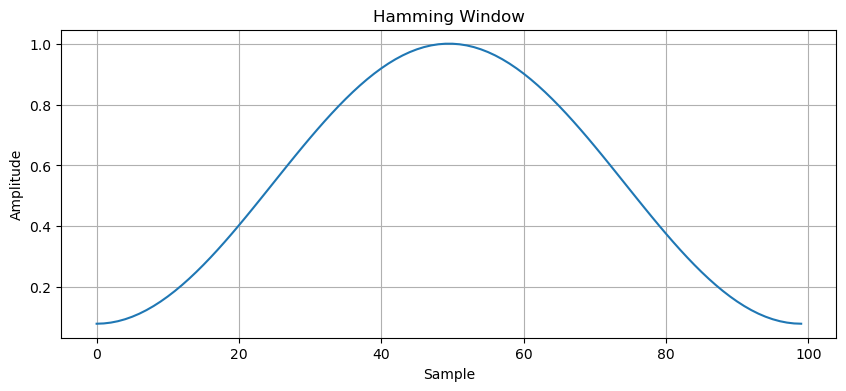

In [5]:
# 创建汉明窗
hamming = np.hamming(frame_length)

# 对每一帧应用汉明窗
frames *= hamming
# 窗的长度
N = 100

# 生成汉明窗
hamming = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(N) / (N - 1))

# 绘制汉明窗的图像
plt.figure(figsize=(10, 4))
plt.plot(hamming)
plt.title('Hamming Window')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


## 4.短时傅里叶变换
 计算每个帧的短时傅里叶变换
## 5.计算功率
 计算每个帧的功率谱

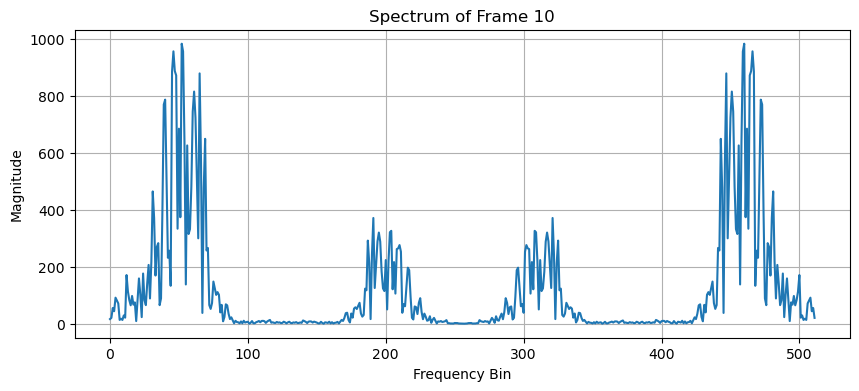

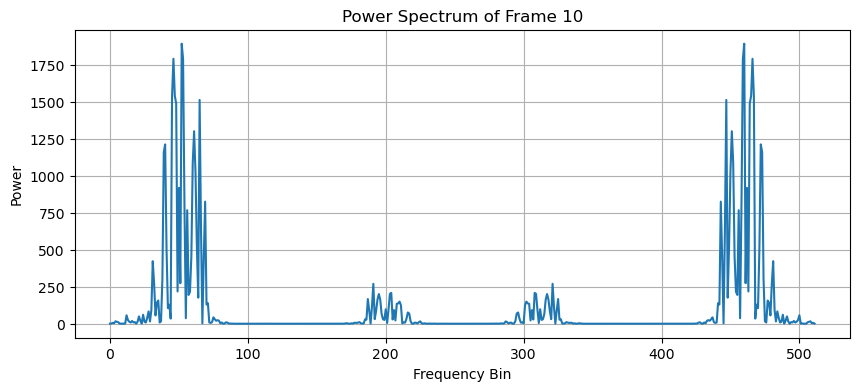

d:\software\anaconda3\envs\ran0torch\lib\site-packages\matplotlib\axes\_axes.py:8091: RuntimeWarning: divide by zero encountered in log10
  Z = 20. * np.log10(spec)


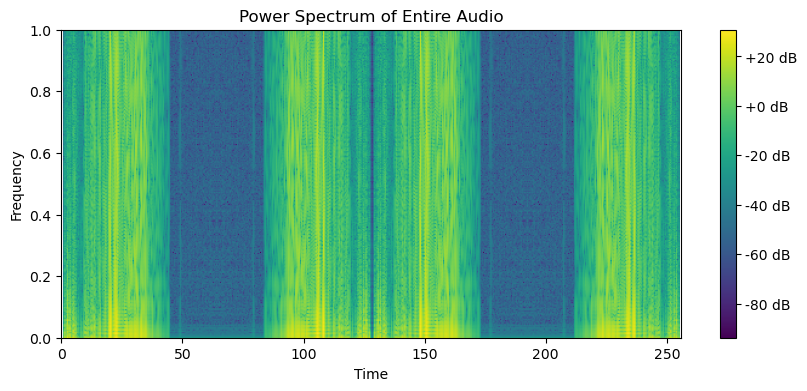

In [6]:
import scipy.fftpack

# 计算FFT大小
NFFT = 512

# 对每一帧应用FFT
mag_frames = np.absolute(scipy.fftpack.fft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

import matplotlib.pyplot as plt

# 选择一帧
frame_index = 10
frame_mag = mag_frames[frame_index]
frame_pow = pow_frames[frame_index]

# 绘制频谱图
plt.figure(figsize=(10, 4))
plt.plot(frame_mag)
plt.title('Spectrum of Frame {}'.format(frame_index))
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

# 绘制功率图
plt.figure(figsize=(10, 4))
plt.plot(frame_pow)
plt.title('Power Spectrum of Frame {}'.format(frame_index))
plt.xlabel('Frequency Bin')
plt.ylabel('Power')
plt.grid(True)
plt.show()

# 绘制功率谱图
plt.figure(figsize=(10, 4))
plt.specgram(pow_frames, NFFT=NFFT, Fs=2, noverlap=0, mode='magnitude')
plt.title('Power Spectrum of Entire Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()



## 6.创建mel滤波器


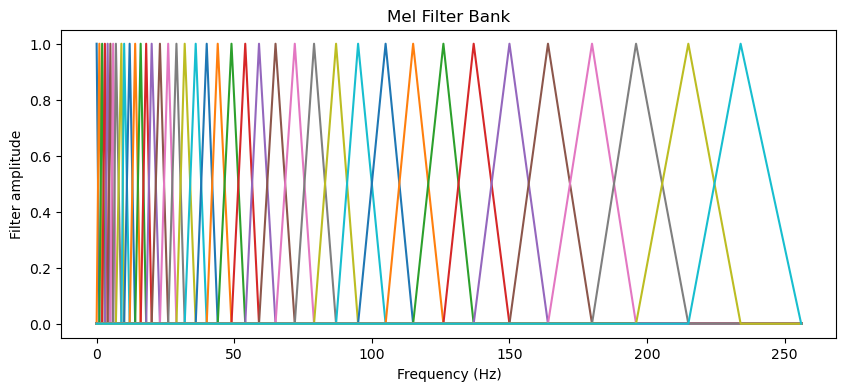

In [7]:
def mel_filter_bank(num_filters, NFFT, sample_rate, low_freq=0, high_freq=None):
    # 如果没有指定高频，则默认为采样率的一半
    high_freq = high_freq or sample_rate / 2
    # 确保高频不超过采样率的一半
    assert high_freq <= sample_rate / 2, "高频必须小于采样率的一半"

    # 将频率转换为Mel频率
    low_mel = hz_to_mel(low_freq)
    high_mel = hz_to_mel(high_freq)

    # 在Mel频率上创建等间距的点
    mel_points = np.linspace(low_mel, high_mel, num_filters + 2)

    # 将Mel点转换为频率
    hz_points = mel_to_hz(mel_points)

    # 将频率转换为FFT bin编号
    bin_points = np.floor((NFFT + 1) * hz_points / sample_rate).astype(int)

    # 创建滤波器组
    filters = np.zeros((num_filters, NFFT // 2 + 1))
    for i in range(1, num_filters + 1):
        # 对于每个滤波器，设置其在对应的FFT bin范围内的值
        filters[i - 1, bin_points[i - 1]:bin_points[i]] = (np.arange(bin_points[i - 1], bin_points[i]) - bin_points[i - 1]) / (bin_points[i] - bin_points[i - 1])
        filters[i - 1, bin_points[i]:bin_points[i + 1]] = 1 - (np.arange(bin_points[i], bin_points[i + 1]) - bin_points[i]) / (bin_points[i + 1] - bin_points[i])

    return filters

# 定义频率到Mel频率的转换函数
def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

# 定义Mel频率到频率的转换函数
def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

# 创建Mel滤波器组
num_filters = 40
mel_filters = mel_filter_bank(num_filters, NFFT, sample_rate)


# 绘制Mel滤波器组
plt.figure(figsize=(10, 4))
for i in range(num_filters):
    plt.plot(mel_filters[i])
plt.title('Mel Filter Bank')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter amplitude')
plt.show()

## 7.应用mel滤波器


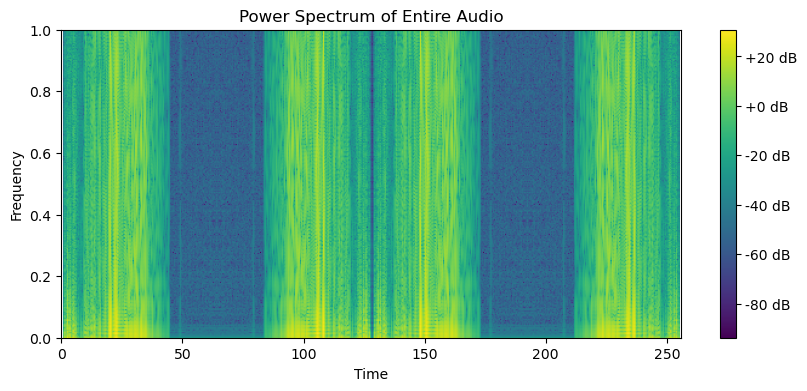

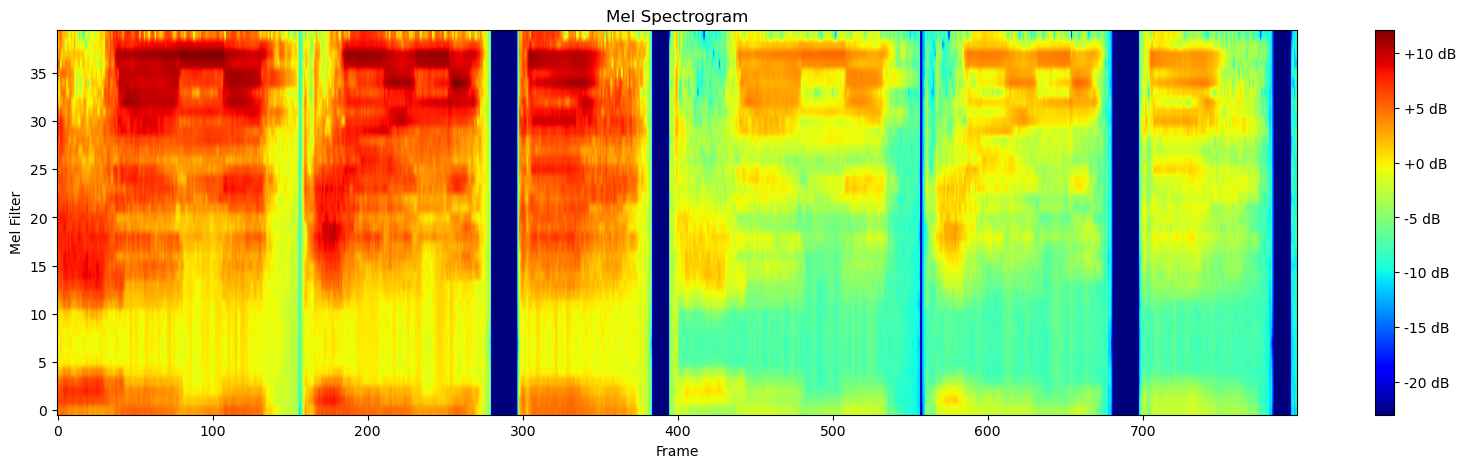

In [8]:
# 取功率谱的正半部分
pow_frames_half = pow_frames[:, :NFFT // 2 + 1]

# 应用Mel滤波器组
mel_spectrogram = np.dot(pow_frames_half, mel_filters.T)

# 对结果取对数，得到Mel频谱
mel_spectrogram = np.log(mel_spectrogram + 1e-10)  # Adding a small number to avoid log(0)


# 绘制功率谱图
plt.figure(figsize=(10, 4))
plt.specgram(pow_frames, NFFT=NFFT, Fs=2, noverlap=0, mode='magnitude')
plt.title('Power Spectrum of Entire Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()


# 绘制Mel频谱图
plt.figure(figsize=(20, 5))
plt.imshow(np.flipud(mel_spectrogram.T), aspect='auto', cmap='jet', origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Frame')
plt.ylabel('Mel Filter')
plt.colorbar(format='%+2.0f dB')
plt.show()


## 8.应用离散余弦变换（DCT）对滤波器组系数去相关处理
## 9.使用正弦提升器改善频谱质量


In [ ]:
from scipy.fftpack import dct

# 计算MFCC系数
num_ceps = 40
mfcc = dct(mel_spectrogram, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]  # Keep 2-13

# 创建正弦提升器
nframes, ncoeff = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (ncoeff / 2) * np.sin(np.pi * n / ncoeff)

# 应用正弦提升器
mfcc *= lift


## 10.比较

d:\software\anaconda3\envs\ran0torch\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=551 is too large for input signal of length=2
  warnings.warn(
d:\software\anaconda3\envs\ran0torch\lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


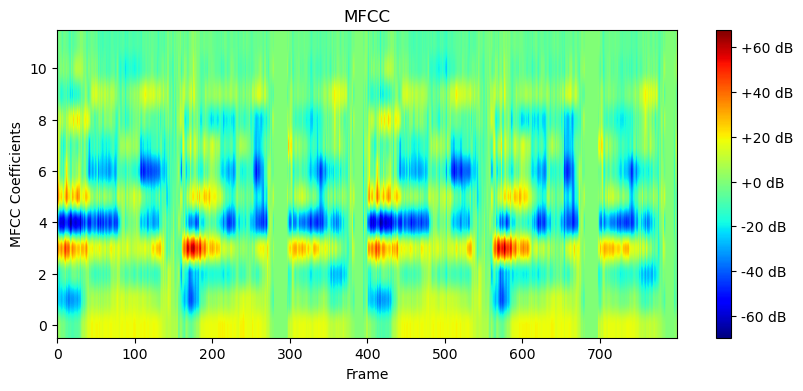

TypeError: Invalid shape (1, 12, 44100) for image data

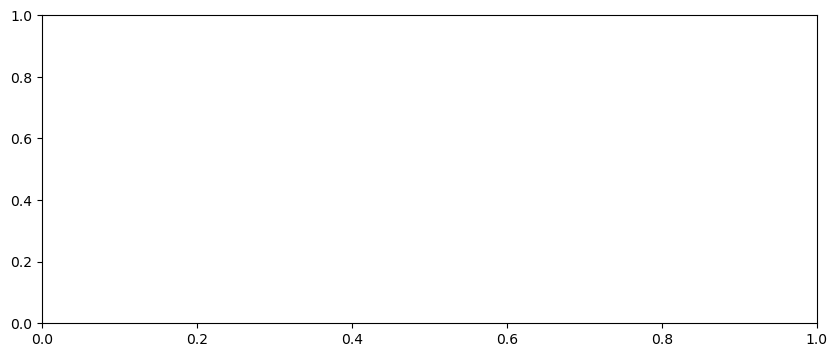

In [10]:
import librosa

# 使用librosa提取MFCC特征
wav1 = wav.astype(np.float32)
mfcc_librosa = librosa.feature.mfcc(y=wav1, sr=sample_rate, n_mfcc=num_ceps,hop_length=frame_step, n_fft=frame_length)
mfcc_librosa = mfcc_librosa.T
# 绘制MFCC系数图

plt.figure(figsize=(10, 4))
plt.imshow(mfcc.T, origin='lower', aspect='auto', cmap='jet')
plt.title('MFCC')
plt.xlabel('Frame')
plt.ylabel('MFCC Coefficients')
plt.colorbar(format='%+2.0f dB')
plt.show()

plt.figure(figsize=(10, 4))
plt.imshow(mfcc_librosa, origin='lower', aspect='auto', cmap='jet')
plt.title('MFCC (Librosa)')
plt.xlabel('Frame')
plt.ylabel('MFCC Coefficients')
plt.colorbar(format='%+2.0f dB')
plt.show()